In [1]:
import os, cv2, json, math, random, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from transformers import AutoImageProcessor, AutoModel
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/ubuntu/cali-recod/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
BASE_DIR  = "./data"
AUTH_DIR  = f"{BASE_DIR}/train_images/authentic"
FORG_DIR  = f"{BASE_DIR}/train_images/forged"
MASK_DIR  = f"{BASE_DIR}/train_masks"
TEST_DIR  = f"{BASE_DIR}/test_images"
DINO_PATH = "facebook/dinov2-base"

IMG_SIZE = 512
BATCH_SIZE = 32
EPOCHS_SEG = 10
LR_SEG = 1e-4
WEIGHT_DECAY = 2e-5
CHANNELS = 4

class ForgerySegDataset(Dataset):
    def __init__(self, auth_paths, forg_paths, mask_dir, img_size=256, transform=False):
        self.transform = transform
        self.samples = []
        for p in forg_paths:
            m = os.path.join(mask_dir, Path(p).stem + ".npy")
            if os.path.exists(m):
                self.samples.append((p, m))
        for p in auth_paths:
            self.samples.append((p, None))
        self.img_size = img_size
        
        # Define transforms once in __init__, not in __getitem__
        if self.transform:
            self.aug = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                # Geometric augmentations
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                # Color augmentations (important for generalization)
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                # Noise/blur (helps with real-world robustness)
                A.GaussianBlur(blur_limit=(3, 5), p=0.2),
                A.GaussNoise(var_limit=(10, 50), p=0.2),
                # JPEG compression artifacts (very relevant for forgery detection!)
                A.ImageCompression(quality_lower=70, quality_upper=100, p=0.3),
                # Convert to tensor (no normalization - processor handles it)
                ToTensorV2(),
            ])
        else:
            self.aug = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                # Convert to tensor (no normalization - processor handles it)
                ToTensorV2(),
            ])
    
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")  # PIL Image (always RGB regardless of source format)
        img = np.array(img)  # numpy (H, W, C) - albumentations expects channels last
        h, w = img.shape[:2]
        
        masks = np.zeros((h, w, CHANNELS), np.uint8)  # (H, W, C) for albumentations
        if mask_path:
            loaded_masks = np.load(mask_path)  # Shape: (num_masks, H, W)
            len_masks = len(loaded_masks)
            # Transpose to (H, W, C)
            for i in range(min(len_masks, CHANNELS)):
                masks[:, :, i] = loaded_masks[i]
        
        # Apply transforms
        transformed = self.aug(image=img, mask=masks)
        img_t = transformed['image']  # Already a tensor with shape (C, H, W), totensorv2 does this
        masks_t = transformed['mask']  # Shape: (H, W, C), totensorv2 does not permute
        
        # Scale image to [0, 1] range (ToTensorV2 keeps [0, 255])
        # forward_features() expects [0, 1] and converts back to [0, 255] for the processor
        img_t = img_t.float() / 255.0
        
        # Transpose mask back to (C, H, W)
        if isinstance(masks_t, np.ndarray):
            masks_t = torch.from_numpy(masks_t.astype(np.float32)).permute(2, 0, 1)
        else:
            masks_t = masks_t.permute(2, 0, 1).float()
        
        # they are now both C,H,W
        return img_t, masks_t


class DinoDecoder(nn.Module):
    """Progressive upsampling decoder with regularization"""
    def __init__(self, in_ch=768, out_ch=CHANNELS, dropout=0.1):
        super().__init__()
        
        # Conv blocks for each upsampling stage (upsampling done in forward with F.interpolate)
        self.up1 = self._block(in_ch, 384, dropout)    # 768 → 384 channels
        self.up2 = self._block(384, 192, dropout)      # 384 → 192 channels
        self.up3 = self._block(192, 96, dropout)       # 192 → 96 channels
        self.up4 = self._block(96, 48, dropout)        # 96 → 48 channels
        
        self.final = nn.Conv2d(48, out_ch, kernel_size=1)
    
    def _block(self, in_ch, out_ch, dropout):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, f, size):
        # Progressive upsampling: 37×37 → 74 → 148 → 296 → 512
        x = F.interpolate(f, scale_factor=2, mode='bilinear', align_corners=False)  # 37 → 74
        x = self.up1(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # 74 → 148
        x = self.up2(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # 148 → 296
        x = self.up3(x)
        
        x = F.interpolate(x, size=size, mode='bilinear', align_corners=False)       # 296 → 512
        x = self.up4(x)
        
        return self.final(x)

class DinoSegmenter(nn.Module):
    def __init__(self, encoder, processor, unfreeze_blocks=3):
        super().__init__()
        self.encoder, self.processor = encoder, processor
        
        # Freeze all parameters first
        for p in self.encoder.parameters():
            p.requires_grad = False
        
        # Unfreeze the last N transformer blocks
        num_blocks = len(self.encoder.encoder.layer)
        for i in range(num_blocks - unfreeze_blocks, num_blocks):
            for p in self.encoder.encoder.layer[i].parameters():
                p.requires_grad = True
        
        # Unfreeze the final layernorm
        for p in self.encoder.layernorm.parameters():
            p.requires_grad = True
        
        self.seg_head = DinoDecoder(768, CHANNELS)

    def forward_features(self, x):
        imgs = (x*255).clamp(0,255).byte().permute(0,2,3,1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(x.device)
        # Remove torch.no_grad() since we're fine-tuning!
        feats = self.encoder(**inputs).last_hidden_state
        B, N, C = feats.shape
        fmap = feats[:, 1:, :].permute(0, 2, 1)
        s = int(math.sqrt(N-1))
        fmap = fmap.reshape(B, C, s, s)
        return fmap

    def forward_seg(self, x):
        fmap = self.forward_features(x)
        return self.seg_head(fmap, (IMG_SIZE, IMG_SIZE))

In [3]:
#  TRAINING
#  MODEL (DINOv2 + Decoder)
processor = AutoImageProcessor.from_pretrained(DINO_PATH)
encoder = AutoModel.from_pretrained(DINO_PATH).eval().to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading weights: 100%|██████████| 223/223 [00:00<00:00, 716.17it/s, Materializing param=layernorm.weight]                                 


In [4]:
auth_imgs = sorted([str(Path(AUTH_DIR)/f) for f in os.listdir(AUTH_DIR)])
forg_imgs = sorted([str(Path(FORG_DIR)/f) for f in os.listdir(FORG_DIR)])
train_auth, val_auth = train_test_split(auth_imgs, test_size=0.2, random_state=42)
train_forg, val_forg = train_test_split(forg_imgs, test_size=0.2, random_state=42)

train_loader = DataLoader(
    ForgerySegDataset(train_auth, train_forg, MASK_DIR, transform=True),  # <-- Enable augmentations!
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    ForgerySegDataset(val_auth, val_forg, MASK_DIR, transform=False),  # <-- No augmentations for validation
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

/tmp/ipykernel_3924/2700101391.py:40: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.2),
/tmp/ipykernel_3924/2700101391.py:42: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=70, quality_upper=100, p=0.3),


In [5]:
model_seg = DinoSegmenter(encoder, processor).to(device)
# load weights
# model_seg.load_state_dict(torch.load("model_seg_final.pt"))

# opt_seg = optim.AdamW(model_seg.seg_head.parameters(), lr=LR_SEG, weight_decay=WEIGHT_DECAY)

# Separate parameter groups with different learning rates
backbone_params = []
decoder_params = []

for name, param in model_seg.named_parameters():
    if param.requires_grad:
        if 'seg_head' in name:
            decoder_params.append(param)
        else:
            backbone_params.append(param)

opt_seg = optim.AdamW([
    {'params': backbone_params, 'lr': LR_SEG / 10},  # 10x smaller LR for backbone
    {'params': decoder_params, 'lr': LR_SEG},
], weight_decay=WEIGHT_DECAY)

pos_weight = torch.tensor([99.0]).to(device)  # Adjust this value
crit_seg = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# crit_seg = nn.BCEWithLogitsLoss()

# baseline
# val_loss = .44, val_f1 = .17
# augmented data: .1783 (10 epochs)
# better model structure: val f1 = .23
# hungarian matching: val f1 = 0.2645 (15 epochs, overfits with more epochs), reached 0.3100 with more epochs
train_losses = []
val_losses = []

In [6]:
from scipy.optimize import linear_sum_assignment

def hungarian_matched_loss(outputs, targets, pos_weight=None):
    """
    Compute BCE loss with Hungarian matching between pred/gt channels.
    
    outputs: (B, C, H, W) - predicted logits
    targets: (B, C, H, W) - ground truth masks
    """
    B, C, H, W = outputs.shape
    device = outputs.device
    
    matched_losses = []
    
    for b in range(B):
        pred = outputs[b]  # (C, H, W)
        tgt = targets[b]   # (C, H, W)
        
        # Build cost matrix: cost[i,j] = BCE(pred_channel_i, gt_channel_j)
        with torch.no_grad():
            cost_matrix = torch.zeros(C, C)
            for i in range(C):
                for j in range(C):
                    cost_matrix[i, j] = F.binary_cross_entropy_with_logits(
                        pred[i], tgt[j], 
                        pos_weight=pos_weight,
                        reduction='mean'
                    )
        
        # Hungarian matching (find optimal assignment)
        row_ind, col_ind = linear_sum_assignment(cost_matrix.cpu().numpy())
        
        # Compute loss for matched pairs (WITH gradients this time)
        for r, c in zip(row_ind, col_ind):
            loss = F.binary_cross_entropy_with_logits(
                pred[r], tgt[c],
                pos_weight=pos_weight,
                reduction='mean'
            )
            matched_losses.append(loss)
    
    return torch.stack(matched_losses).mean()

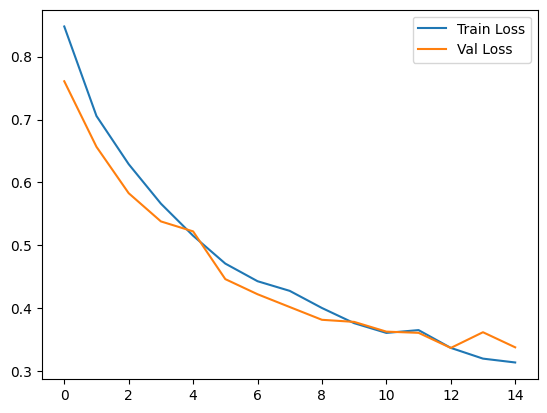

In [9]:
# plot train and val losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

In [8]:
EPOCHS_SEG = 15
best_val_loss = float('inf')

for e in range(EPOCHS_SEG):
    model_seg.train()
    total_train_loss = 0
    for x, m in tqdm(train_loader, desc=f"[Segmentation] Epoch {e+1}/{EPOCHS_SEG}"):
        x, m = x.to(device), m.to(device)
        outputs = model_seg.forward_seg(x)
        loss = hungarian_matched_loss(outputs, m, pos_weight=pos_weight)
        opt_seg.zero_grad()
        loss.backward()
        opt_seg.step()
        total_train_loss += loss.item()
    print(f"  → train_avg_loss={total_train_loss/len(train_loader):.4f}")
    train_losses.append(total_train_loss/len(train_loader))

    # compute val loss
    model_seg.eval()
    total_val_loss = 0
    for x, m in tqdm(val_loader, desc="Validation"):
        x, m = x.to(device), m.to(device)
        outputs = model_seg.forward_seg(x)
        loss = hungarian_matched_loss(outputs, m, pos_weight=pos_weight)
        total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss/len(val_loader)
    print(f"  → val_avg_loss={avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"  ★ New best val loss: {best_val_loss:.4f}. Saving model...")
        torch.save(model_seg.state_dict(), "model_seg_best.pt")

torch.save(model_seg.state_dict(), "model_seg_final.pt")

[Segmentation] Epoch 1/15: 100%|██████████| 129/129 [02:27<00:00,  1.15s/it]


  → avg_loss=0.8480


Validation: 100%|██████████| 33/33 [00:38<00:00,  1.16s/it]


  → avg_loss=0.7609


[Segmentation] Epoch 2/15: 100%|██████████| 129/129 [01:55<00:00,  1.12it/s]


  → avg_loss=0.7056


Validation: 100%|██████████| 33/33 [00:25<00:00,  1.29it/s]


  → avg_loss=0.6566


[Segmentation] Epoch 3/15: 100%|██████████| 129/129 [01:51<00:00,  1.15it/s]


  → avg_loss=0.6290


Validation: 100%|██████████| 33/33 [00:27<00:00,  1.19it/s]


  → avg_loss=0.5828


[Segmentation] Epoch 4/15: 100%|██████████| 129/129 [01:57<00:00,  1.10it/s]


  → avg_loss=0.5662


Validation: 100%|██████████| 33/33 [00:26<00:00,  1.23it/s]


  → avg_loss=0.5379


[Segmentation] Epoch 5/15: 100%|██████████| 129/129 [01:55<00:00,  1.12it/s]


  → avg_loss=0.5151


Validation: 100%|██████████| 33/33 [00:25<00:00,  1.32it/s]


  → avg_loss=0.5220


[Segmentation] Epoch 6/15: 100%|██████████| 129/129 [01:52<00:00,  1.15it/s]


  → avg_loss=0.4708


Validation: 100%|██████████| 33/33 [00:28<00:00,  1.15it/s]


  → avg_loss=0.4461


[Segmentation] Epoch 7/15: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s]


  → avg_loss=0.4428


Validation: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]


  → avg_loss=0.4221


[Segmentation] Epoch 8/15: 100%|██████████| 129/129 [02:03<00:00,  1.04it/s]


  → avg_loss=0.4274


Validation: 100%|██████████| 33/33 [00:25<00:00,  1.28it/s]


  → avg_loss=0.4017


[Segmentation] Epoch 9/15: 100%|██████████| 129/129 [01:56<00:00,  1.11it/s]


  → avg_loss=0.4002


Validation: 100%|██████████| 33/33 [00:25<00:00,  1.29it/s]


  → avg_loss=0.3814


[Segmentation] Epoch 10/15: 100%|██████████| 129/129 [01:56<00:00,  1.11it/s]


  → avg_loss=0.3760


Validation: 100%|██████████| 33/33 [00:26<00:00,  1.25it/s]


  → avg_loss=0.3781


[Segmentation] Epoch 11/15: 100%|██████████| 129/129 [01:56<00:00,  1.11it/s]


  → avg_loss=0.3605


Validation: 100%|██████████| 33/33 [00:24<00:00,  1.33it/s]


  → avg_loss=0.3626


[Segmentation] Epoch 12/15: 100%|██████████| 129/129 [01:58<00:00,  1.08it/s]


  → avg_loss=0.3650


Validation: 100%|██████████| 33/33 [00:26<00:00,  1.27it/s]


  → avg_loss=0.3606


[Segmentation] Epoch 13/15: 100%|██████████| 129/129 [01:50<00:00,  1.17it/s]


  → avg_loss=0.3367


Validation: 100%|██████████| 33/33 [00:24<00:00,  1.34it/s]


  → avg_loss=0.3366


[Segmentation] Epoch 14/15: 100%|██████████| 129/129 [01:58<00:00,  1.09it/s]


  → avg_loss=0.3196


Validation: 100%|██████████| 33/33 [00:26<00:00,  1.25it/s]


  → avg_loss=0.3616


[Segmentation] Epoch 15/15: 100%|██████████| 129/129 [01:55<00:00,  1.12it/s]


  → avg_loss=0.3135


Validation: 100%|██████████| 33/33 [00:29<00:00,  1.11it/s]


  → avg_loss=0.3376


In [10]:
@torch.no_grad()
def segment_prob_map_all_channels(pil):
    """Returns probability maps for ALL channels (not just channel 0)."""
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    return torch.sigmoid(model_seg.forward_seg(x))[0].cpu().numpy()  # Shape: (CHANNELS, H, W)

def enhanced_adaptive_mask(prob, alpha_grad=0.35):
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm

    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    return mask, thr

def finalize_mask(prob, orig_size):
    mask, thr = enhanced_adaptive_mask(prob)
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr

def pipeline_final(pil):
    """Returns a LIST of masks (one per detected forged region) instead of a single merged mask."""
    probs = segment_prob_map_all_channels(pil)  # (CHANNELS, H, W)
    
    all_masks = []
    all_areas = []
    all_means = []
    all_thrs = []
    
    for ch in range(probs.shape[0]):
        prob = probs[ch]
        mask, thr = finalize_mask(prob, pil.size)
        area = int(mask.sum())
        
        if area > 0:
            prob_resized = cv2.resize(prob, pil.size, interpolation=cv2.INTER_LINEAR)
            mean_inside = float(prob_resized[mask == 1].mean())
        else:
            mean_inside = 0.0
        
        # Filter out small/weak detections
        if area >= 400 and mean_inside >= 0.35:
            all_masks.append(mask)
            all_areas.append(area)
            all_means.append(mean_inside)
            all_thrs.append(thr)
    
    if len(all_masks) == 0:
        # No valid masks found
        return "authentic", [], {"area": 0, "mean_inside": 0.0, "thr": 0.0}
    
    total_area = sum(all_areas)
    avg_mean = sum(all_means) / len(all_means)
    avg_thr = sum(all_thrs) / len(all_thrs)
    
    return "forged", all_masks, {"area": total_area, "mean_inside": avg_mean, "thr": avg_thr, "num_masks": len(all_masks)}

In [11]:
@torch.no_grad()
def segment_prob_map_all_channels(pil):
    """Returns probability maps for ALL channels (not just channel 0)."""
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    return torch.sigmoid(model_seg.forward_seg(x))[0].cpu().numpy()  # Shape: (CHANNELS, H, W)

def enhanced_adaptive_mask(prob, alpha_grad=0.35):
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm

    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    return mask, thr

def finalize_mask(prob, orig_size):
    mask, thr = enhanced_adaptive_mask(prob)
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr

def pipeline_final(pil):
    """Returns a LIST of masks (one per detected forged region) instead of a single merged mask."""
    probs = segment_prob_map_all_channels(pil)  # (CHANNELS, H, W)
    
    all_masks = []
    all_areas = []
    all_means = []
    all_thrs = []
    
    for ch in range(probs.shape[0]):
        prob = probs[ch]
        mask, thr = finalize_mask(prob, pil.size)
        area = int(mask.sum())
        
        if area > 0:
            prob_resized = cv2.resize(prob, pil.size, interpolation=cv2.INTER_LINEAR)
            mean_inside = float(prob_resized[mask == 1].mean())
        else:
            mean_inside = 0.0
        
        # Filter out small/weak detections
        if area >= 400 and mean_inside >= 0.35:
            all_masks.append(mask)
            all_areas.append(area)
            all_means.append(mean_inside)
            all_thrs.append(thr)
    
    if len(all_masks) == 0:
        # No valid masks found
        return "authentic", [], {"area": 0, "mean_inside": 0.0, "thr": 0.0}
    
    total_area = sum(all_areas)
    avg_mean = sum(all_means) / len(all_means)
    avg_thr = sum(all_thrs) / len(all_thrs)
    
    return "forged", all_masks, {"area": total_area, "mean_inside": avg_mean, "thr": avg_thr, "num_masks": len(all_masks)}

In [12]:
import json

import numba
import numpy as np
from numba import types
import numpy.typing as npt
import pandas as pd
import scipy.optimize
import torch
from concurrent.futures import ThreadPoolExecutor


class ParticipantVisibleError(Exception):
    pass


@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def rle_encode(masks: list[npt.NDArray], fg_val: int = 1) -> str:
    """
    Adapted from contrails RLE https://www.kaggle.com/code/inversion/contrails-rle-submission
    Args:
        masks: list of numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encodings as a string, with each RLE JSON-encoded and separated by a semicolon.
    """
    return ';'.join([json.dumps(_rle_encode_jit(x, fg_val)) for x in masks])


@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img


def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e


# ===================== GPU-ACCELERATED SCORING FUNCTIONS =====================

def calculate_f1_matrix_gpu(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray], device='cuda'):
    """
    GPU-accelerated F1 matrix calculation.
    Computes F1 scores for all pairs of predicted and ground truth masks in parallel.
    
    Parameters:
    pred_masks: List of predicted binary masks (each is height x width)
    gt_masks: List of ground truth binary masks (each is height x width)
    device: 'cuda' or 'cpu'
    
    Returns:
    numpy array of shape (num_pred, num_gt) containing F1 scores
    """
    if not torch.cuda.is_available():
        device = 'cpu'
    
    num_pred = len(pred_masks)
    num_gt = len(gt_masks)
    
    if num_pred == 0 or num_gt == 0:
        return np.zeros((max(num_pred, num_gt), num_gt))
    
    # Stack and flatten masks, convert to GPU tensors
    # Shape: (num_pred, H*W) and (num_gt, H*W)
    pred_flat = torch.stack([torch.from_numpy(m.flatten().astype(np.float32)) for m in pred_masks]).to(device)
    gt_flat = torch.stack([torch.from_numpy(m.flatten().astype(np.float32)) for m in gt_masks]).to(device)
    
    # Expand dims for broadcasting: pred (num_pred, 1, H*W), gt (1, num_gt, H*W)
    pred_expanded = pred_flat.unsqueeze(1)  # (num_pred, 1, H*W)
    gt_expanded = gt_flat.unsqueeze(0)       # (1, num_gt, H*W)
    
    # Compute TP, FP, FN for all pairs at once using broadcasting
    # This creates (num_pred, num_gt, H*W) intermediate tensors
    tp = torch.sum((pred_expanded == 1) & (gt_expanded == 1), dim=2).float()  # (num_pred, num_gt)
    fp = torch.sum((pred_expanded == 1) & (gt_expanded == 0), dim=2).float()
    fn = torch.sum((pred_expanded == 0) & (gt_expanded == 1), dim=2).float()
    
    # Compute precision and recall
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Handle edge cases where tp + fp or tp + fn is 0
    precision = torch.where((tp + fp) > 0, precision, torch.zeros_like(precision))
    recall = torch.where((tp + fn) > 0, recall, torch.zeros_like(recall))
    
    # Compute F1
    f1_matrix = 2 * precision * recall / (precision + recall + 1e-10)
    f1_matrix = torch.where((precision + recall) > 0, f1_matrix, torch.zeros_like(f1_matrix))
    
    f1_matrix = f1_matrix.cpu().numpy()
    
    # Pad if needed
    if f1_matrix.shape[0] < num_gt:
        f1_matrix = np.vstack((f1_matrix, np.zeros((num_gt - f1_matrix.shape[0], num_gt))))
    
    return f1_matrix


def calculate_f1_matrix_gpu_batched(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray], 
                                     device='cuda', batch_size=50):
    """
    Memory-efficient GPU F1 matrix calculation with batching.
    Use this for large numbers of masks to avoid GPU OOM.
    """
    if not torch.cuda.is_available():
        device = 'cpu'
    
    num_pred = len(pred_masks)
    num_gt = len(gt_masks)
    
    if num_pred == 0 or num_gt == 0:
        return np.zeros((max(num_pred, num_gt), num_gt))
    
    # Pre-convert all masks to tensors on GPU
    pred_tensors = [torch.from_numpy(m.flatten().astype(np.float32)).to(device) for m in pred_masks]
    gt_tensors = [torch.from_numpy(m.flatten().astype(np.float32)).to(device) for m in gt_masks]
    
    f1_matrix = np.zeros((num_pred, num_gt), dtype=np.float32)
    
    # Process in batches to avoid OOM
    for i_start in range(0, num_pred, batch_size):
        i_end = min(i_start + batch_size, num_pred)
        pred_batch = torch.stack(pred_tensors[i_start:i_end])  # (batch, H*W)
        
        for j_start in range(0, num_gt, batch_size):
            j_end = min(j_start + batch_size, num_gt)
            gt_batch = torch.stack(gt_tensors[j_start:j_end])  # (batch, H*W)
            
            # Broadcast and compute
            pred_exp = pred_batch.unsqueeze(1)  # (batch_pred, 1, H*W)
            gt_exp = gt_batch.unsqueeze(0)       # (1, batch_gt, H*W)
            
            tp = torch.sum((pred_exp == 1) & (gt_exp == 1), dim=2).float()
            fp = torch.sum((pred_exp == 1) & (gt_exp == 0), dim=2).float()
            fn = torch.sum((pred_exp == 0) & (gt_exp == 1), dim=2).float()
            
            precision = torch.where((tp + fp) > 0, tp / (tp + fp), torch.zeros_like(tp))
            recall = torch.where((tp + fn) > 0, tp / (tp + fn), torch.zeros_like(tp))
            
            f1 = torch.where((precision + recall) > 0, 
                            2 * precision * recall / (precision + recall), 
                            torch.zeros_like(precision))
            
            f1_matrix[i_start:i_end, j_start:j_end] = f1.cpu().numpy()
    
    # Pad if needed
    if f1_matrix.shape[0] < num_gt:
        f1_matrix = np.vstack((f1_matrix, np.zeros((num_gt - f1_matrix.shape[0], num_gt))))
    
    return f1_matrix


def oF1_score_gpu(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray], device='cuda'):
    """
    GPU-accelerated optimal F1 score calculation.
    Uses GPU for F1 matrix computation, CPU for Hungarian algorithm.
    """
    # Use batched version for memory efficiency
    f1_matrix = calculate_f1_matrix_gpu_batched(pred_masks, gt_masks, device=device)
    
    # Hungarian algorithm runs on CPU (scipy)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image_gpu(label_rles: str, prediction_rles: str, shape_str: str, device='cuda') -> float:
    """GPU-accelerated single image evaluation."""
    shape = json.loads(shape_str)
    label_masks = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_masks = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score_gpu(prediction_masks, label_masks, device=device)


def score_gpu(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, 
              device='cuda', num_workers: int = 1, return_details: bool = True):
    """
    GPU-accelerated scoring function with parallel processing.
    
    Args:
        solution: Ground truth DataFrame
        submission: Submission DataFrame  
        row_id_column_name: Column name for row IDs
        device: 'cuda' or 'cpu'
        num_workers: Number of parallel workers for batch processing
        return_details: If True, returns (score, details_df) tuple
        
    Returns:
        If return_details=True: (float, pd.DataFrame) - score and detailed results per row
        If return_details=False: float - just the score
    """
    import gc
    import traceback
    
    df = solution.copy()
    df = df.rename(columns={'annotation': 'label'})
    df['prediction'] = submission['annotation']
    
    # Initialize result columns
    df['image_score'] = 0.0
    df['success'] = True
    df['error_msg'] = ''
    df['eval_type'] = 'pending'
    df['num_pred_masks'] = 0
    df['num_gt_masks'] = 0
    df['shape_parsed'] = ''
    # Keep existing 'image' column if present, otherwise initialize empty
    if 'image' not in df.columns:
        df['image'] = ''
    
    # Identify authentic vs forged
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    
    # Handle authentic cases
    df.loc[authentic_indices, 'image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)
    df.loc[authentic_indices, 'eval_type'] = 'authentic'
    
    # Get rows that need evaluation
    eval_indices = df.loc[~authentic_indices].index.tolist()
    
    if len(eval_indices) == 0:
        final_score = float(np.mean(df['image_score']))
        if return_details:
            return final_score, df
        return final_score
    
    print(f"Evaluating {len(eval_indices)} forged images on GPU...")
    
    # Process sequentially to better handle memory and catch errors per-row
    for idx in tqdm(eval_indices, desc="GPU Scoring"):
        row = df.loc[idx]
        try:
            # Parse shape for debugging
            shape = json.loads(row['shape'])
            df.loc[idx, 'shape_parsed'] = str(shape)
            df.loc[idx, 'image'] = row['image']
            
            # Count masks
            label_rles = row['label'].split(';')
            pred_rles = row['prediction'].split(';')
            df.loc[idx, 'num_gt_masks'] = len(label_rles)
            df.loc[idx, 'num_pred_masks'] = len(pred_rles)
            
            # Evaluate
            result = evaluate_single_image_gpu(row['label'], row['prediction'], row['shape'], device=device)
            df.loc[idx, 'image_score'] = result
            df.loc[idx, 'eval_type'] = 'forged_evaluated'
            df.loc[idx, 'success'] = True
            
        except torch.cuda.OutOfMemoryError as e:
            df.loc[idx, 'success'] = False
            df.loc[idx, 'error_msg'] = f"CUDA OOM: {str(e)}"
            df.loc[idx, 'eval_type'] = 'error_oom'
            df.loc[idx, 'image_score'] = 0.0
            print(f"\n⚠️ CUDA OOM at index {idx}: {str(e)[:100]}")
            # Try to recover
            torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            df.loc[idx, 'success'] = False
            df.loc[idx, 'error_msg'] = f"{type(e).__name__}: {str(e)}"
            df.loc[idx, 'eval_type'] = 'error_other'
            df.loc[idx, 'image_score'] = 0.0
            print(f"\n⚠️ Error at index {idx}: {type(e).__name__}: {str(e)[:100]}")
            
        # Periodically clear GPU cache
        if idx % 50 == 0:
            torch.cuda.empty_cache()
            gc.collect()
    
    final_score = float(np.mean(df['image_score']))
    
    # Print summary
    num_success = df['success'].sum()
    num_failed = (~df['success']).sum()
    print(f"\n✅ Completed: {num_success} succeeded, {num_failed} failed")
    print(f"📊 Final score: {final_score:.4f}")
    
    if return_details:
        return final_score, df
    return final_score


# ===================== LEGACY CPU FUNCTIONS (kept for compatibility) =====================

def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0


def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """CPU version - use calculate_f1_matrix_gpu for faster processing."""
    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix


def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """CPU version - use oF1_score_gpu for faster processing."""
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """CPU version - use score_gpu for faster processing."""
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    def eval_wrapped(row):
        result = evaluate_single_image(row['label'], row['prediction'], row['shape'])
        print(f"finished one image, image_score: {result}")
        return result

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        eval_wrapped, axis=1
    )
    return float(np.mean(df['image_score']))

In [13]:
solution = []
submission = []

val_items = [(p, "forged") for p in val_forg]
val_items += [(p, "authentic") for p in val_auth]
results = []

for p, status in tqdm(val_items, desc="Validation forged-only"):
    pil = Image.open(p).convert("RGB")
    label, masks_pred, dbg = pipeline_final(pil)  # masks_pred is now a LIST of masks

    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    
    # Convert ground truth to list if it's 3D (N, H, W), otherwise wrap in list
    if m_gt.ndim == 3:
        gt_masks_list = [m_gt[i] for i in range(m_gt.shape[0])]
        our_shape = m_gt.shape[1:]
    else:
        gt_masks_list = [m_gt]
        our_shape = m_gt.shape
    
    # Prepare predicted masks list - resize to match ground truth shape if needed
    if label == "authentic" or len(masks_pred) == 0:
        pred_masks_list = []
    else:
        pred_masks_list = []
        for m in masks_pred:
            m_resized = cv2.resize((m > 0).astype(np.uint8), (our_shape[1], our_shape[0]), interpolation=cv2.INTER_NEAREST)
            if m_resized.sum() > 0:  # Only add non-empty masks
                pred_masks_list.append(m_resized)
    
    # Encode using the list-based rle_encode (joins with ';')
    solution_ann = "authentic" if status == "authentic" else rle_encode(gt_masks_list)
    submission_ann = "authentic" if len(pred_masks_list) == 0 else rle_encode(pred_masks_list)

    solution.append({ "annotation": str(solution_ann), "shape": str(list(our_shape)), "image": p})
    submission.append({ "annotation": str(submission_ann), "shape": str(list(our_shape)), "image": p})

Validation forged-only: 100%|██████████| 1027/1027 [01:33<00:00, 10.96it/s]


In [14]:
submissionDF = pd.DataFrame(submission)
solutionDF = pd.DataFrame(solution)
# make row_id column
submissionDF['row_id'] = submissionDF.index
solutionDF['row_id'] = solutionDF.index

In [15]:
# Use GPU-accelerated scoring (returns score and detailed results DataFrame)
final_score, results_df = score_gpu(solutionDF, submissionDF, "row_id", device=device)

print(f"\nFinal Score: {final_score:.4f}")

# Show failed rows for debugging
failed_df = results_df[~results_df['success']]
if len(failed_df) > 0:
    print(f"\n❌ Failed rows ({len(failed_df)}):")
    print(failed_df[['row_id', 'eval_type', 'error_msg', 'num_gt_masks', 'num_pred_masks', 'shape_parsed']].to_string())

Evaluating 507 forged images on GPU...


GPU Scoring: 100%|██████████| 507/507 [00:07<00:00, 67.47it/s] 


✅ Completed: 1027 succeeded, 0 failed
📊 Final score: 0.2699

Final Score: 0.2699


In [ ]:
results_df

In [ ]:
index = 984
image = Image.open(results_df.iloc[index]['image'])

results_df.iloc[index]
image

In [ ]:
our_shape = json.loads(results_df.iloc[index]['shape'])
gt_mask = [rle_decode(x, our_shape) for x in results_df.iloc[index]['label'].split(';')][0]
pred_mask = [rle_decode(x, our_shape) for x in results_df.iloc[index]['prediction'].split(';')][0]

In [ ]:
image

In [ ]:
plt.imshow(image)
plt.imshow(pred_mask, alpha=0.2)
plt.show()



In [ ]:
submissionDF[submissionDF.row_id ==40]

In [ ]:
submissionDF.iloc[2]['annotation'].split(';')

In [ ]:
import os, json, cv2
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- RLE Encoder for Kaggle Submission (handles MULTIPLE masks) ---
def rle_encode_single(mask: np.ndarray, fg_val: int = 1) -> str:
    """Encode a single 2D mask to RLE JSON string."""
    pixels = mask.T.flatten()
    dots = np.where(pixels == fg_val)[0]
    if len(dots) == 0:
        return None  # Empty mask
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return json.dumps([int(x) for x in run_lengths])

def rle_encode_multi(masks: list, fg_val: int = 1) -> str:
    """Encode multiple masks, joining with semicolons (competition format)."""
    encoded = []
    for m in masks:
        enc = rle_encode_single((m > 0).astype(np.uint8), fg_val)
        if enc is not None:
            encoded.append(enc)
    return ';'.join(encoded) if encoded else "authentic"

# --- Paths ---
TEST_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
SAMPLE_SUB = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
OUT_PATH = "submission.csv"

rows = []
for f in tqdm(sorted(os.listdir(TEST_DIR)), desc="Inference on Test Set"):
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, masks, dbg = pipeline_final(pil)  # masks is now a LIST of masks

    # Annotation finale
    if label == "authentic" or len(masks) == 0:
        annot = "authentic"
    else:
        annot = rle_encode_multi(masks)

    rows.append({
        "case_id": Path(f).stem,
        "annotation": annot,
        "area": int(dbg.get("area", 0)),
        "mean": float(dbg.get("mean_inside", 0.0)),
        "thr": float(dbg.get("thr", 0.0)),
        "num_masks": int(dbg.get("num_masks", len(masks) if masks else 0))
    })


sub = pd.DataFrame(rows)
ss = pd.read_csv(SAMPLE_SUB)
ss["case_id"] = ss["case_id"].astype(str)
sub["case_id"] = sub["case_id"].astype(str)
final = ss[["case_id"]].merge(sub, on="case_id", how="left")
final["annotation"] = final["annotation"].fillna("authentic")
final[["case_id", "annotation"]].to_csv(OUT_PATH, index=False)

print(f"\n✅ Saved submission file: {OUT_PATH}")
print(final.head(10))


sample_files = sorted(os.listdir(TEST_DIR))[:5]
for f in sample_files:
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, masks, dbg = pipeline_final(pil)
    
    # Combine all masks for visualization (overlay them)
    if label == "authentic" or len(masks) == 0:
        combined_mask = np.zeros(pil.size[::-1], np.uint8)
    else:
        combined_mask = np.zeros(pil.size[::-1], np.uint8)
        for m in masks:
            combined_mask = np.maximum(combined_mask, (m > 0).astype(np.uint8))

    print(f"{'🔴' if label=='forged' else '🟢'} {f}: {label} | area={dbg.get('area', 0)} mean={dbg.get('mean_inside', 0):.3f} | num_masks={len(masks) if masks else 0}")

    if label == "authentic":
        plt.figure(figsize=(5,5))
        plt.imshow(pil)
        plt.title(f"{f} — Authentic")
        plt.axis("off")
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(pil)
        plt.imshow(combined_mask, alpha=0.45, cmap="Reds")
        plt.title(f"Predicted Forged Masks ({len(masks)})\nArea={dbg.get('area', 0)} | Mean={dbg.get('mean_inside', 0):.3f}")
        plt.axis("off")
        plt.show()


In [17]:
# ==================== PREPARE LOCAL TEST ENVIRONMENT ====================
# This cell copies validation images to test_images so you can run submission.ipynb locally

import shutil

# Local paths (matches submission.ipynb LOCAL_MODE)
LOCAL_TEST_DIR = "./data/test_images"
LOCAL_GT_DIR = "./data/ground_truth"

# Clear and create directories
if os.path.exists(LOCAL_TEST_DIR):
    shutil.rmtree(LOCAL_TEST_DIR)
os.makedirs(LOCAL_TEST_DIR, exist_ok=True)
os.makedirs(LOCAL_GT_DIR, exist_ok=True)

print("📁 Created local test directory structure")

# 1. Copy validation images to test directory
print("\n📷 Copying validation images to test directory...")
val_all = val_forg + val_auth
for p in tqdm(val_all, desc="Copying images"):
    dst = os.path.join(LOCAL_TEST_DIR, os.path.basename(p))
    shutil.copy2(p, dst)
print(f"   Copied {len(val_all)} images to {LOCAL_TEST_DIR}")

# 2. Save ground truth for scoring
print("\n🎯 Saving ground truth for scoring...")
gt_data = []
for p in tqdm(val_all, desc="Saving ground truth"):
    case_id = Path(p).stem
    mask_path = os.path.join(MASK_DIR, f"{case_id}.npy")
    
    if p in val_forg and os.path.exists(mask_path):
        # Forged image - load and save mask
        masks = np.load(mask_path)
        np.save(os.path.join(LOCAL_GT_DIR, f"{case_id}.npy"), masks)
        gt_data.append({
            "case_id": case_id,
            "label": "forged",
            "mask_file": f"{case_id}.npy",
            "shape": list(masks.shape[1:]) if masks.ndim == 3 else list(masks.shape)
        })
    else:
        # Authentic image
        img = Image.open(p)
        gt_data.append({
            "case_id": case_id,
            "label": "authentic",
            "mask_file": None,
            "shape": [img.height, img.width]
        })

gt_df = pd.DataFrame(gt_data)
gt_df.to_csv(os.path.join(LOCAL_GT_DIR, "ground_truth.csv"), index=False)
print(f"   Saved ground truth for {len(gt_df)} images")
print(f"   Forged: {(gt_df['label'] == 'forged').sum()}, Authentic: {(gt_df['label'] == 'authentic').sum()}")

print("\n✅ Local test environment ready!")
print(f"   Test images: {LOCAL_TEST_DIR}")
print(f"   Ground truth: {LOCAL_GT_DIR}")
print("\n   Now run submission.ipynb with LOCAL_MODE = True")

📁 Created local test directory structure

📷 Copying validation images to test directory...


Copying images: 100%|██████████| 1027/1027 [00:43<00:00, 23.88it/s]


   Copied 1027 images to ./data/test_images

🎯 Saving ground truth for scoring...


Saving ground truth: 100%|██████████| 1027/1027 [00:34<00:00, 29.99it/s] 

   Saved ground truth for 1027 images
   Forged: 551, Authentic: 476

✅ Local test environment ready!
   Test images: ./data/test_images
   Ground truth: ./data/ground_truth

   Now run submission.ipynb with LOCAL_MODE = True
